# Lichess Puzzles Analysis

## Background

[lichess](https://lichess.org/), a free and open-source website for playing and learning chess, publishes a [database](https://database.lichess.org/#puzzles) of (among other things) all chess puzzles available on their website.

I wanted to go through the puzzles database to see if I could find any interesting patterns.

### What are Puzzles?

In a chess puzzle, the solver is given a position (taken from a real game on lichess), and their task is to find a sequence of moves that significantly improves their odds of then winning the game. This can mean finding moves leading to checkmates, favorable trades, threats, and the like.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
puzzles = pd.read_csv("lichess_db_puzzle.csv")

In [3]:
puzzles.head()

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1877,76,95,8786,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1501,73,96,35000,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN
2,0008Q,8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64,e7f7 f5e5 e2f1 e5e6,1355,76,91,743,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#127,NaN
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1103,74,88,603,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...
4,000Pw,6k1/5p1p/4p3/4q3/3nN3/2Q3P1/PP3P1P/6K1 w - - 2 37,e4d2 d4e2 g1f1 e2c3,1422,74,92,604,crushing endgame fork short,https://lichess.org/au2lCK5o#73,NaN


Here is my understanding of what each column stands for. The **Notes** section of the [database source page](https://database.lichess.org/#puzzles) has more details on some of these columns.

- `PuzzleId`: A unique identifier for each puzzle
- `FEN`: Short for [Forsyth–Edwards Notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation), this is a standard notation for describing a particular board position of a chess game. It reflects the position before the opponent makes their move
- `Moves`: Given in [UCI](https://en.wikipedia.org/wiki/Universal_Chess_Interface) notation, these are the moves (separated by spaces) that lead to a favorable outcome, i.e. the solution of the puzzle.
- `Rating`: A rough measure of puzzle difficulty
- `Popularity`: A rought measure (ranging between -100 and +100) of how well-liked a particular puzzle is. Derived from user-received upvotes and downvotes, details of which are given on the database source page.
- `NbPlays`: The number of times a particular puzzle has been played by different users
- `Themes`: A list of tags describing the nature of the puzzle
- `GameUrl`: The URL of the game the puzzle was taken from
- `OpeningTags`: A list of tags describing the kind of opening seen in the puzzle, provided the puzzle position starts within the first 20 moves of a game

I'm not sure what the `RatingDeviation` column stands for, and no information is provided on the database source page. I therefore didn't consider this column in my analysis

## Exploring the Data

I like to start off by looking at the unique values in each column. This helps me find inconsistencies to clean up later, and also to come up with questions to guide my analysis. Sorting the unique results before displaying is also useful so I can look for particular entries.

In [4]:
def get_sorted_unique(col_name):
    return np.sort(puzzles[col_name].dropna().unique())

I explore all the columns in the table one-by-one.

In [5]:
get_sorted_unique("OpeningTags")

array(['Alekhine_Defense Alekhine_Defense_Balogh_Variation',
       'Alekhine_Defense Alekhine_Defense_Brooklyn_Variation',
       'Alekhine_Defense Alekhine_Defense_Exchange_Variation', ...,
       'Zukertort_Opening Zukertort_Opening_Vos_Gambit',
       'Zukertort_Opening Zukertort_Opening_Wade_Defense',
       'Zukertort_Opening Zukertort_Opening_Ware_Defense'],
      shape=(1423,), dtype=object)

## Analysis

We'll need the number of puzzles quite frequently in the analysis, so let's start by storing that in a variable.

In [6]:
num_puzzles = puzzles.shape[0]

### Which themes are the most common?

Let's take a look at some recurring themes in the puzzles. We plot the five most common themes

In [7]:
themes = pd.Series((" ".join(puzzles["Themes"])).split(" "))

In [8]:
themes_frequency = themes.value_counts()

In [9]:
top_five_themes = themes_frequency.iloc[:5].map(lambda count: (count / num_puzzles) * 100)

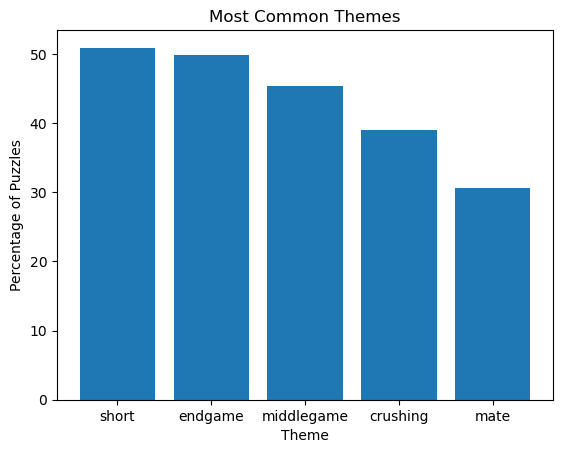

In [10]:
plt.bar(top_five_themes.index, top_five_themes)
plt.xlabel("Theme")
plt.ylabel("Percentage of Puzzles")
plt.title("Most Common Themes")
plt.show()

Note that since a puzzle may have multiple themes, the percentages don't add up to 100. Each percentage measure above refers simply to the proportion of puzzles containing a particular theme.

### How many puzzles have opening tags?

Some puzzles start within the first 20 moves of the game they're taken from. The dataset entry for such a puzzle has a set of non-null opening tags in the `OpeningTags` column.

Let's determine the proportion of these "Opening Puzzles".

In [11]:
is_opening = pd.Series(puzzles["OpeningTags"].notna(), name="is_opening")

In [12]:
opening_count = pd.Series(puzzles.groupby(is_opening)["PuzzleId"].count(), name="opening_count")

In [13]:
opening_proportion = opening_count.map(lambda count: (count / num_puzzles) * 100)

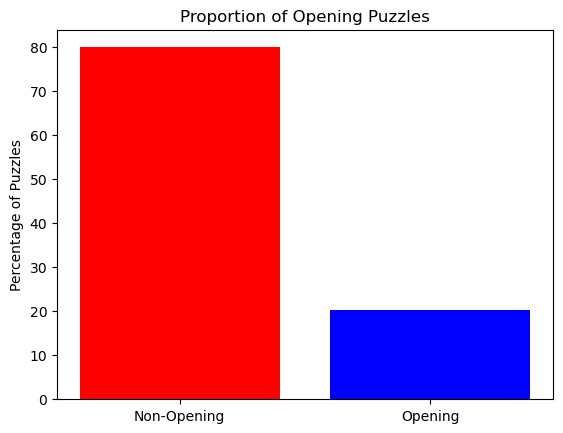

In [14]:
plt.bar(["Non-Opening", "Opening"], opening_proportion, color=["red", "blue"])
plt.ylabel("Percentage of Puzzles")
plt.title("Proportion of Opening Puzzles")
plt.show()

### Which opening tags are the most common?

Like we did for themes above, let's figure out five of the most commonly occuring opening tags.

In [15]:
opening_tags = pd.Series(" ".join(puzzles["OpeningTags"].dropna()).split(" "))

In [16]:
opening_tags_frequency = opening_tags.value_counts()

In [17]:
num_opening_puzzles = opening_count.loc[True]

In [18]:
top_five_opening_tags = opening_tags_frequency.iloc[:5].map(lambda count: (count / num_opening_puzzles) * 100)

We plot the most commonly occuring opening tags as percentages of the Opening Puzzle count.

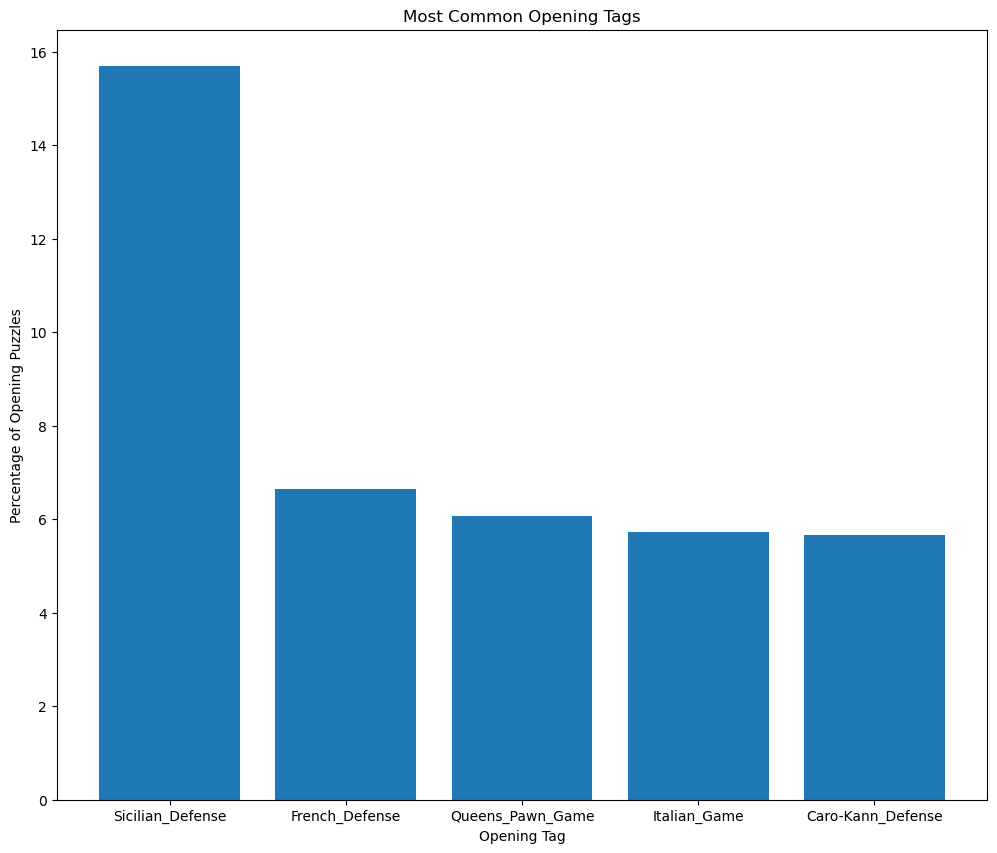

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
plt.bar(top_five_opening_tags.index, top_five_opening_tags)
plt.xlabel("Opening Tag")
plt.ylabel("Percentage of Opening Puzzles")
plt.title("Most Common Opening Tags")
plt.show()

### How does puzzle popularity relate to number of plays?

I wanted to know if there was any meaningful relationship between how popular a puzzle is and how many times it's been played. Since there are millions of entries, I take samples (300 random entries each) of the `Popularity` and `NbPlays` to avoid clutter, and plot them against each other.

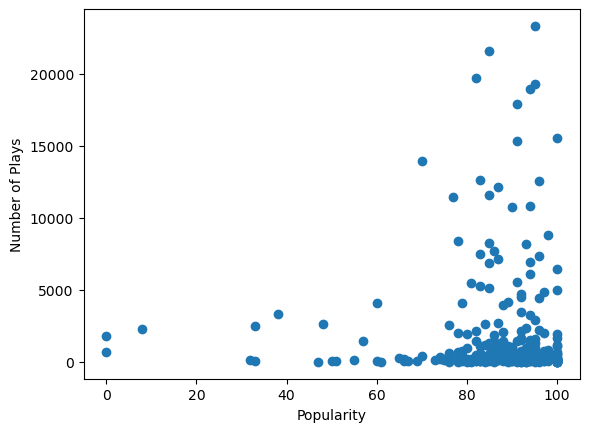

In [20]:
plt.scatter(x=puzzles["Popularity"].sample(n=300), y=puzzles["NbPlays"].sample(n=300))
plt.xlabel("Popularity")
plt.ylabel("Number of Plays")
plt.show()

There doesn't seem to be any meaningful relationship between popularity and number of plays. To confirm this, we can check to see that the correlation coefficient is only about `0.19`.

In [21]:
round(puzzles["Popularity"].corr(puzzles["NbPlays"]), 2)

np.float64(0.19)

### How does puzzle popularity relate to puzzle rating?

Similar to what we just saw, I create a scatter plot between equal-sized random samples of puzzle rating and popularity.

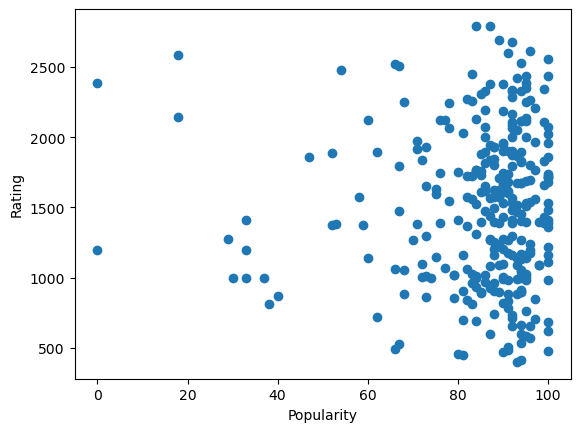

In [22]:
plt.scatter(x=puzzles["Popularity"].sample(n=300), y=puzzles["Rating"].sample(n=300))
plt.xlabel("Popularity")
plt.ylabel("Rating")
plt.show()

Again, there doesn't seem to be any meaningful relationship, and a correlation coefficient of just about `-0.04` confirms this.

In [23]:
round(puzzles["Popularity"].corr(puzzles["Rating"]), 2)

np.float64(-0.04)

### Proportion of Puzzles by Popularity

To make the popularity score less obscure, I decided to categorize popularity ratings into four distinct classes:

- -100 to -50: `Very Unpopular`
- -49 to 0: `Unpopuar`
- 1 to 50: `Popular`
- 51 to 100: `Very Popular`

In [24]:
bins = [-100, -50, 0, 50, 100]

In [25]:
popularity_categories = pd.cut(puzzles["Popularity"], bins=bins, labels=["Very Unpopular", "Unpopular", "Popular", "Very Popular"])

In [26]:
popularity_counts = puzzles.groupby(popularity_categories, observed=True)["PuzzleId"].count()

In [27]:
popularity_percentages = popularity_counts.map(lambda count: (count / num_puzzles) * 100)

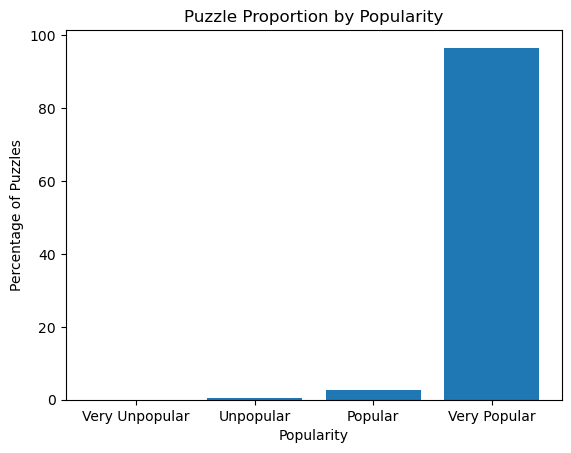

In [28]:
plt.bar(popularity_percentages.index, popularity_percentages)
plt.xlabel("Popularity")
plt.ylabel("Percentage of Puzzles")
plt.title("Puzzle Proportion by Popularity")
plt.show()

Most of the puzzles seem to be very popular (popularity score between 51 and 100). It seems users generally seem to upvote (or at least avoid downvoting) puzzles for the most part!

### Frequency of Move Count in Solution

Each puzzle takes a fixed number of moves to solve. Let's see what numbers of moves to a solution are most common.

In [29]:
num_moves = puzzles["Moves"].map(lambda moves: len(moves.split(" ")))

In [30]:
num_moves_frequency = num_moves.value_counts()

In [31]:
num_moves_frequency

Moves
4     2871557
6     1466634
2      797457
8      329636
10      89832
12      28628
14      10153
16       3835
18       1398
20        593
22        222
24         80
26         40
28         15
30          4
32          1
34          1
Name: count, dtype: int64

In [32]:
top_five_move_counts = num_moves_frequency.iloc[:5].map(lambda count: (count / num_puzzles) * 100)
top_five_move_counts.index = top_five_move_counts.index.map({2: "two", 4: "four", 6: "six", 8: "eight", 10: "ten"})

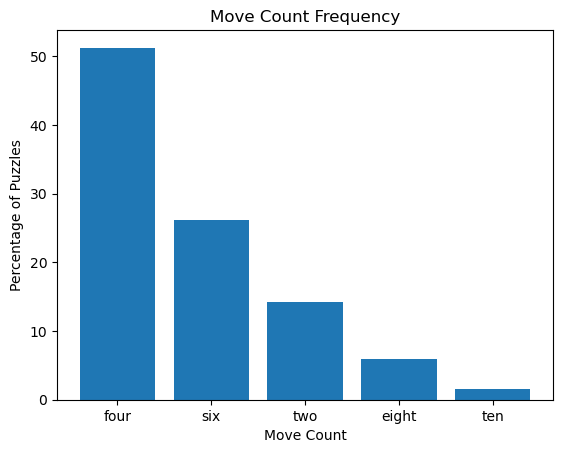

In [33]:
plt.bar(top_five_move_counts.index, top_five_move_counts)
plt.xlabel("Move Count")
plt.ylabel("Percentage of Puzzles")
plt.title("Move Count Frequency")
plt.show()

Roughly half of all puzzles have four moves to a solution (including the opponent's moves).